In [44]:
import os
import json
from collections import OrderedDict

from evaluate_lanenet_on_tusimple import eval_lanenet
from modules.homo_util import homoify
from modules.video_util import videoify
%matplotlib inline

In [2]:
DATA_PATH = "../test_set"
JSON_PATH = "outputs/json/"
SAVE_DIR = "outputs/seg_results/"
VID_DIR = "outputs/vids/"

CONST_IMAGE = (1312, 1312)
LANENET_WEIGHTS="weights/tusimple_lanenet.ckpt"

In [3]:
# frames_dir = "../test_set/clips/0531/1492626499813320696"
frames_dir = "../test_set/clips/0530/1492626191132352208_0"

In [4]:
clip_num = "_".join(frames_dir.split("/")[3:])
save_json = os.path.join(JSON_PATH, clip_num + ".json")
vid_path = os.path.join(VID_DIR, clip_num + ".mp4")
clip_num

'0530_1492626191132352208_0'

Detecting Lanes using lanenet

In [5]:
print("Detecting lanes")
lanes_json = eval_lanenet(frames_dir, LANENET_WEIGHTS, SAVE_DIR, save_json)
print("Lanes detected")
lanes_json = OrderedDict(sorted(lanes_json.items(), key=lambda x: int(x[0].split("/")[-1].split(".")[0])))

Detecting lanes


100%|██████████| 20/20 [00:09<00:00,  2.20it/s]

Lanes detected


In [6]:
lanes_json.keys()

odict_keys(['clips/0530/1492626191132352208_0/1.jpg', 'clips/0530/1492626191132352208_0/2.jpg', 'clips/0530/1492626191132352208_0/3.jpg', 'clips/0530/1492626191132352208_0/4.jpg', 'clips/0530/1492626191132352208_0/5.jpg', 'clips/0530/1492626191132352208_0/6.jpg', 'clips/0530/1492626191132352208_0/7.jpg', 'clips/0530/1492626191132352208_0/8.jpg', 'clips/0530/1492626191132352208_0/9.jpg', 'clips/0530/1492626191132352208_0/10.jpg', 'clips/0530/1492626191132352208_0/11.jpg', 'clips/0530/1492626191132352208_0/12.jpg', 'clips/0530/1492626191132352208_0/13.jpg', 'clips/0530/1492626191132352208_0/14.jpg', 'clips/0530/1492626191132352208_0/15.jpg', 'clips/0530/1492626191132352208_0/16.jpg', 'clips/0530/1492626191132352208_0/17.jpg', 'clips/0530/1492626191132352208_0/18.jpg', 'clips/0530/1492626191132352208_0/19.jpg', 'clips/0530/1492626191132352208_0/20.jpg'])

Yolo

In [7]:
frames_dir

'../test_set/clips/0530/1492626191132352208_0'

In [8]:
YOLO_WEIGHTS = "../yolov7/yolov7.pt"
YOLO_PATH = "outputs/yolo"
CONF = 0.25
SOURCE = frames_dir
IMG_SIZE = 1280

In [9]:
os.system(f"python ../yolov7/detect.py --weights {YOLO_WEIGHTS} --source {SOURCE} --conf {CONF} --img-size {IMG_SIZE} --save-txt --project {YOLO_PATH}")
print("YOLO done")

YOLO done


Homography

In [10]:
final_frames = homoify(lanes_json, DATA_PATH, YOLO_PATH, CONST_IMAGE)
print("Final Frames ready for video writing")

Final Frames ready for video writing


Writing Video

In [85]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [110]:
def read_imgs(frames_dir):
    frames = [frames_dir + "/" + x for x in os.listdir(frames_dir)]
    frames = sorted(frames, key=lambda x: int(x.split("/")[-1].split(".")[0]))
    frames = [cv2.imread(x) for x in frames]
    frames = [cv2.cvtColor(x, cv2.COLOR_BGR2RGB) for x in frames]
    return frames

def text(num_lanes, num_objs):
    return f"Number of lanes: {num_lanes} \n Number of objects: {num_objs}"

def videoify(clip_num, final_frames, vid_path, save_dir, const_image=(1312, 1312)):
    laneNetResultsPath = os.path.join(save_dir,clip_num)
    instanceSegResultsPath = f"{laneNetResultsPath}/instance_seg"
    sourceResultsPath = f"{laneNetResultsPath}/result"
    instanceSeg = read_imgs(instanceSegResultsPath)
    source = read_imgs(sourceResultsPath)


    # vid = cv2.VideoWriter(vid_path, cv2.VideoWriter_fourcc(*'mp4v'), 4, const_image)
    for idx in range(len(final_frames)):
        top_view = final_frames[idx]['img']
        num_lanes = final_frames[idx]['num_lanes']
        num_objs = final_frames[idx]['num_objs']
        black_img = np.zeros((const_image[0], const_image[1], 3), np.uint8)
        black_img = cv2.putText(black_img, text(num_lanes, num_objs), (20, const_image[0] // 2), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 2)
        # plt.imshow(top_view)
        # plt.show()
        # plt.imshow(instanceSeg[idx])
        # plt.show()
        # plt.imshow(source[idx])
        # plt.show()
        plt.imshow(black_img)
        plt.show()
        break
        vid.write(final_frames(idx))
    # vid.release()
    
    return "Video Written"

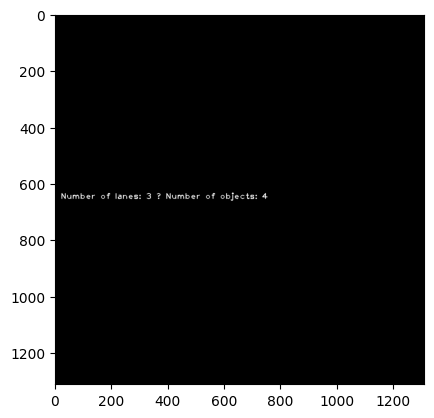

Video written in outputs/vids/0530_1492626191132352208_0.mp4


In [111]:
videoify("/".join(frames_dir.split("/")[-2:]), final_frames, vid_path, SAVE_DIR, CONST_IMAGE)
print(f"Video written in {vid_path}")